In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=4)
    #w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.65:8787/status,
Dashboard: http://10.148.0.65:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.65:46964,Workers: 0
Dashboard: http://10.148.0.65:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Create csv files

In [4]:
zarrs_cutoff = sorted(glob(os.path.join('/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/cutoff_matchup', '*_2.zarr')))

In [5]:
zarrs = sorted(glob(os.path.join('/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/matchup', '*')))

In [6]:
for i in range(len(zarrs)) :
    ds0 = xr.open_dataset(zarrs_cutoff[i])[['drifter_acc_x_25','drifter_coriolis_x_25']]
    ds1 = xr.open_dataset(zarrs[i])[['drogue_status','drifter_acc_x_0','drifter_coriolis_x_0','aviso_alti_ggx_adt', 'aviso_drifter_ggx_adt', 'es_cstrio_z15_drifter_wd_x', 'es_cstrio_z15_alti_wd_x']]
    path = os.path.join('/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err', zarrs[i].split('/')[-1].replace('zarr', 'csv'))
    df = xr.merge([ds0, ds1]).to_dataframe()
    df.where(df.drogue_status).dropna().to_csv(path)#only drogued drifters
    print(path)

/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2010.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2011.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2012.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2013.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2014.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2015.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2016.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2017.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2018.csv
/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2

# Preparation

In [7]:
zarrs = glob(os.path.join('/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/coloc_err', '*'))

In [8]:
df = dd.concat([pd.read_csv(z) for z in zarrs])

In [ ]:
df = df.compute()

In [ ]:
len(df)

In [ ]:
dl = 5000
df["distbin"] = (df.alti___distance // dl) * dl

In [ ]:
df = df.rename(columns = {'aviso_alti_ggx_adt':'ggx', 
          'aviso_drifter_ggx_adt':'ggxd', 
           'drifter_acc_x_25':'acc',
           'drifter_coriolis_x_25':'cor',
           'es_cstrio_z15_drifter_wd_x':'wd',
          })[['obs','acc','cor','drogue_status','ggx','ggxd','wd','alti___distance','alti___time_difference','lat','lon','time','distbin']]

In [ ]:
df['da'] = (df.ggx - df.ggxd)#ggx diff
df['sd']  = df.acc + df.cor + df.ggxd + df.wd #seq (no coloc error)
df['s']  = df.acc + df.cor + df.ggx + df.wd #s with colocation error

var = ['acc', 'cor', 'ggx', 'wd']
vard = ['acc', 'cor', 'ggxd', 'wd']

# Correlation with ggx diff
for v in var : 
    df[v+'da'] = df.da*df[v]
df['ggxdda'] = df.da*df.ggxd

df['sda'] = df['da']*df['s']
df['sdda'] = df['da']*df['sd']

df2 = df[[v for v in df if v not in['obs','drogue_status','alti___distance','alti___time_difference','lat','lon','time','distbin' ]]]**2 # mean square values
df2['distbin'] =df['distbin']

In [ ]:
df_ = df.where(df.alti___distance<25000).dropna()
df2_ = df2.where(df.alti___distance<25000).dropna()
print(len(df_))

_________
# Distribution on DL

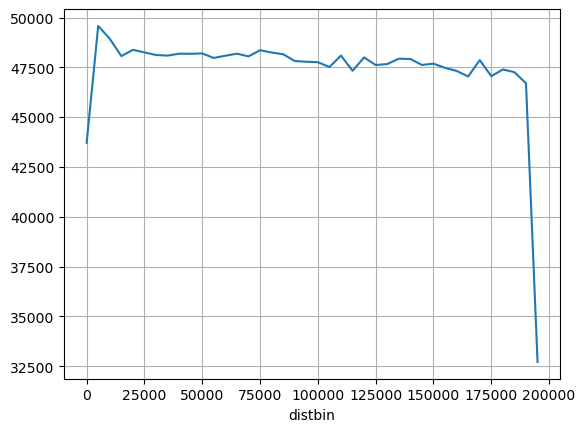

In [35]:
count = df.groupby("distbin").ggx.count()
count.plot()
plt.grid()

____________
___________

# Notations

On reconstruit l'équation du moment avec 4 termes : 
$$ a_1 + a_2 +a_3 +a_4 = s $$
Le résidu $s$ rassemble toutes les erreurs liées à la reconstruction, et peut-être divisée en trois erreurs : 
$$s = n+m+c$$
- $n$ du bruit, qui n'est pas du signal physique (bruit, mauvaise estimation du terme etc)
- $m$ du signal physique non équilibré
- $c$ erreur de colocalisation liée au fait que le terme de gradient n'est pas estimé à la même position

Les lettres majuscules désignent la moyenne du carré sur l'ensemble des colocalisations des valeurs associées

____________
____________

# Etude calcul de l'erreur de colocalisation en fonction de la difference de gradient : MQ $$ C = \langle (a'_3 - a_3)^2 \rangle $$

- Equilibre sans erreur de colocalisation : $a_1 + a_2 +a_3 +a_4 = o_{eq} = s_{eq} $, ou $o = n + m$
  
- Equilibre reconstruit, avec erreur de colocalisation : $a_1 + a_2 +a'_3 +a_4 = c + o = s $

Et en notant $(a'_3 - a_3) = d_a$
$$ c = a'_3 - a_3 + o_{eq} - o = d_a + o_{eq} - o$$


$$ S - S_{eq} = \langle (c+o)^2 \rangle - O_{eq} = D_a + 2\langle d_a o_{eq} \rangle $$
avec $\langle d_a o_{eq} \rangle$ petit devant $D_a$ et $O_eq$ : 
$\langle d_a o_{eq} \rangle/D_a = -16.1\%$ pour DL<25km 
$\langle d_a o_{eq} \rangle/S_{eq} = -2\%$ pour DL<25km 

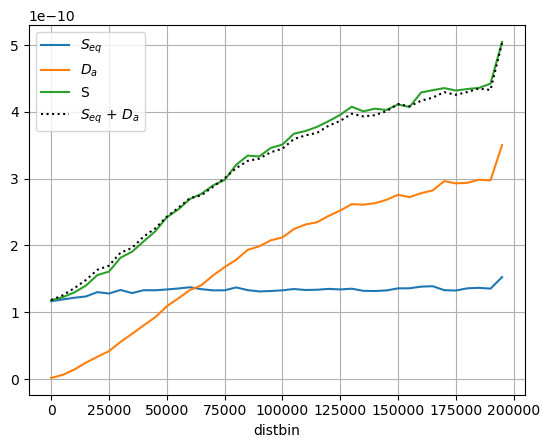

In [36]:
df2['sd2_da2']=df2.sd+df2.da
df2.groupby("distbin").sd.mean().plot(label = r'$S_{eq}$')
df2.groupby("distbin").da.mean().plot(label = r'$D_a$')
df2.groupby("distbin").s.mean().plot(label = 'S')
df2.groupby("distbin").sd2_da2.mean().plot(label = r'$S_{eq}$ + $D_a$', c='k', ls=':')
plt.legend()
plt.grid()

In [1]:
2*df_['sdda'].mean()/df2_['da'].mean()

NameError: name 'df_' is not defined

In [38]:
df_['sdda'].mean()/df2_['sd'].mean()

-0.02134367357869633

____________
____________
# Décomposition des différents termes 
- Pour l'équilibre sans erreur de colocalisation, on a $a_{ieq} = b_{ieq} + e_{ieq} = b_{ieq} + o_{ieq}$ et d'après (H1):
   $$B_{ieq} = \langle b_{i}^2 \rangle = -\sum_{j \neq i} \langle a_ia_j \rangle$$
   $$E_{ieq} = O_{ieq}=\langle a_is_{eq} \rangle$$

- Quand est-il du cas avec erreur de colocalisation ?

  - Pour $i\neq3$: $a_i = b_i + e_i = b_i + o_i$
  - Pour $i=3$: $a'_3 = b'_3 + o'_3 + c'_3 = a'_3 - a_3 + a_3 = d_a + b_{3eq} + o_{3eq}$

ATTENTION : Nous continuons à noter $B_i = -\sum_{j \neq i} \langle a_ia_j \rangle$ et $E_i = \langle a_is \rangle  $ mais nous n'avons plus $B_i = \langle b^2_i \rangle$ ! (notation à changer plus tard)
## Comparaison des $B_{i}$ en fonction des $B_{ieq}$ (sans hypothèses)

- Pour $i\neq3$, par exemple i=1:
$ B_1 - B_{1eq} = -\langle a_1 a_2 \rangle - \langle a_1 a_3 \rangle -\langle a_1 a_4 \rangle +\langle a_1 a_2 \rangle +\langle a_1 a'_3 \rangle + \langle a_1 a_4 \rangle = -\langle a_1 d_a \rangle $

- Pour $i=3$:
$ B_3 - B_{3eq} = -\sum_{j\neq 3}\langle a_j d_a \rangle $

Vérifié sur le plot ci-dessous 

$$ \sum_i (B_i - B_{ieq}) = -2\sum_{j\neq 3}\langle a_j d_a \rangle$$

## Lien $B_i$ à $\langle b^2_i \rangle$?
  - Pour $i\neq3$, par exemple i=1 on a :
         $ B_1 = B_{1eq} -\langle a_1 d_a \rangle = \langle b_{i}^2 \rangle -\langle a_1 d_a \rangle = \langle b_{i}^2 \rangle -\langle b_1 d_a \rangle -\langle o_1 d_a \rangle$
  - Pour $i=3$:
        $ B_3  = \langle b_3^2 \rangle -\sum_{j\neq 3}\langle a_j d_a \rangle $
La vraie partie équilibrée du signal est donc cachée sous $\langle a_1 d_a \rangle$ ou $-\sum_{j\neq i}\langle a_j d_a \rangle$ 

In [39]:
from itertools import combinations
comb = list(combinations(var, 2))
combd = list(combinations(vard, 2))
for c in comb :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]
for c in combd :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]

In [40]:
for v in var :
    df['b_'+v] = -df[[f'{c[0]}_{c[1]}' for c in comb if v in f'{c[0]}_{c[1]}']].sum(axis=1)

for v in vard :
    df['bd_'+v] = -df[[f'{c[0]}_{c[1]}' for c in combd if v in f'{c[0]}_{c[1]}']].sum(axis=1)

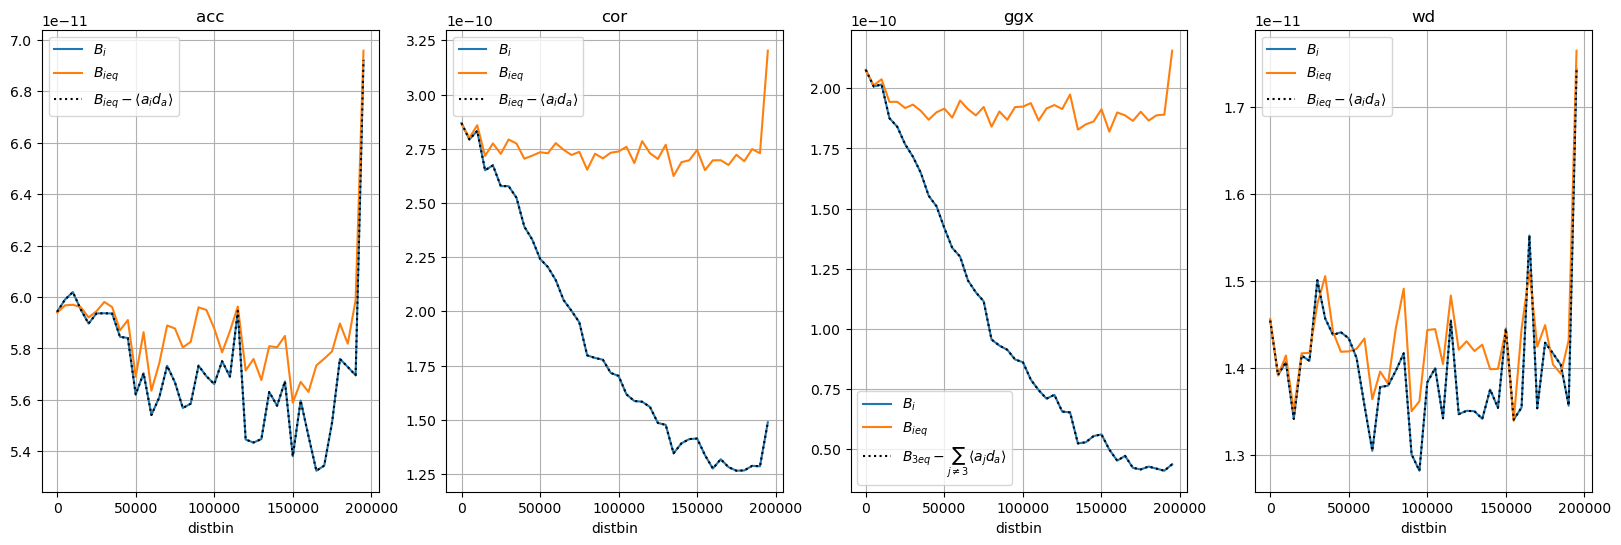

In [41]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df.groupby("distbin")['b_'+v].mean().plot(label=r'$B_i$', ax=ax)
    df.groupby("distbin")['bd_'+vd].mean().plot(label=r'$B_{ieq}$', ax=ax)
    if v != 'ggx':
        (-df.groupby("distbin")[v+'da'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_{ieq} - \langle a_i d_a \rangle$', ax=ax, c='k', ls=':')
    else:
        (-df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1)+ df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_{3eq} - \sum_{j\neq 3}\langle a_j d_a \rangle$', ax=ax, c='k', ls=':')
    #(df.groupby("distbin")[vd+'e'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_{ieq} + \langle a_{ieq} e \rangle$', ax=ax, c='b', ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

## Comparaison des $E_{i}$ en fonction des $E_{ieq}$

- Pour $i\neq3$, par exemple i=1:
$ E_1 - E_{1eq} = \langle a_1 d_a \rangle $

- Pour $i=3$:
$ E_3 - E_{3eq} = \langle a'_3s \rangle - \langle a_3 s_{eq} \rangle = \langle d_a\sum_{j\neq3} a_j\rangle + A'_3 -A_3$

- Nous avons bien : $S = \sum_i E_i = D_a + O_{eq} + 2\langle d_a o_{eq} \rangle$
  avec $2\langle d_a o_{eq} \rangle$ petit devant $D_a$ (voir ci-dessus)

In [42]:
for v in var :
    df[v+'s'] =  df[v] * df['s']
    df2[v+'s'] = df[v+'s']

for v in vard :
    df[v+'sd'] =  df[v] * df['sd']
    df2[v+'sd'] = df[v+'sd']

df['sumb'] = df[['b_'+v for v in var]].sum(axis=1)
df['sumbd'] = df[['bd_'+v for v in vard]].sum(axis=1)
df['sume'] = df[[v+'s' for v in var]].sum(axis=1)
df['sumed'] = df[[v+'sd' for v in vard]].sum(axis=1)

df_ = df.where(df.alti___distance<25000).dropna()
df2_ = df2.where(df.alti___distance<25000).dropna()

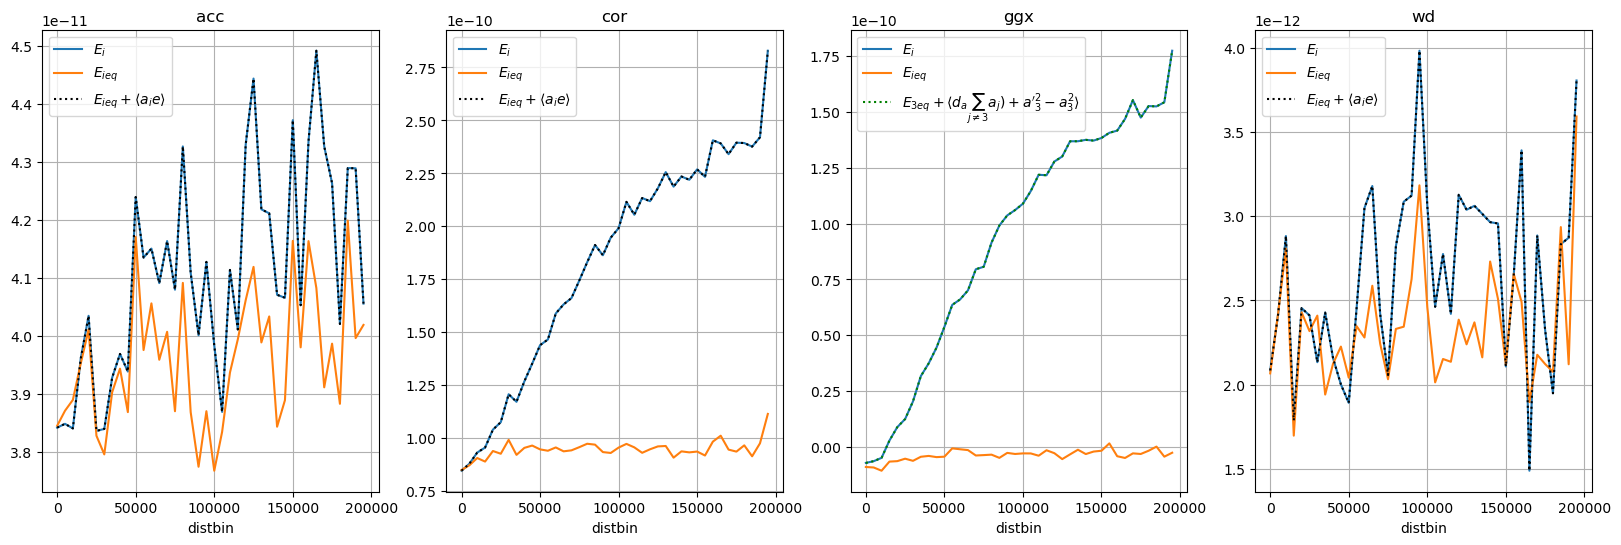

In [43]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df.groupby("distbin")[v+'s'].mean().plot(label=r'$E_i$', ax=ax)
    df.groupby("distbin")[vd+'sd'].mean().plot(label=r'$E_{ieq}$', ax=ax)
    if v!= 'ggx':
        (df.groupby("distbin")[v+'da'].mean() + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r'$E_{ieq} + \langle a_i e \rangle$', ax=ax, c='k', ls=':')
    else:
         (df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1) + df2.groupby("distbin")['ggx'].mean() - df2.groupby("distbin")['ggxd'].mean() + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r"$E_{3eq} + \langle d_a\sum_{j\neq3} a_j) + a'^2_3 -a^2_3 \rangle$", ax=ax, c='g', ls=':')
         #(df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1)  + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r"$E_{3eq} + \langle d_a\sum_{j\neq3} a_j) + a'^2_3 -a^2_3 \rangle$", ax=ax, c='g', ls=':')
    
    ax.grid()
    ax.set_title(v)
    ax.legend()

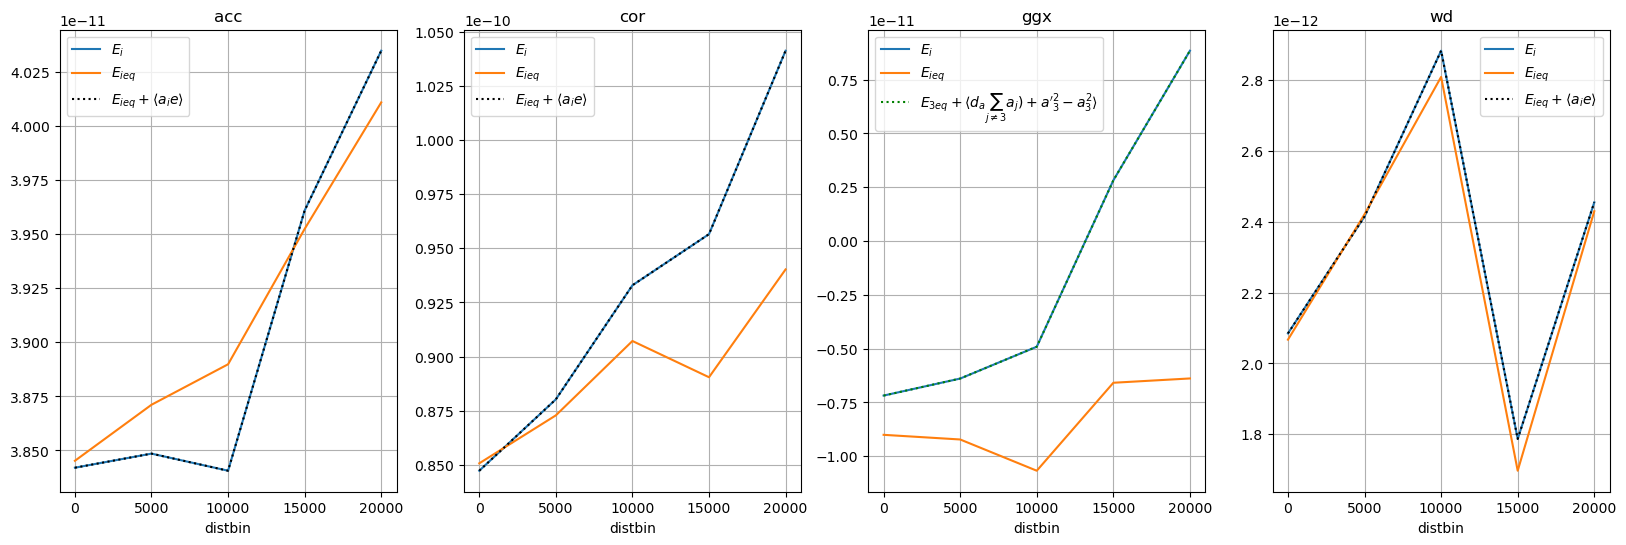

In [44]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df_.groupby("distbin")[v+'s'].mean().plot(label=r'$E_i$', ax=ax)
    df_.groupby("distbin")[vd+'sd'].mean().plot(label=r'$E_{ieq}$', ax=ax)
    if v!= 'ggx':
        (df_.groupby("distbin")[v+'da'].mean() + df_.groupby("distbin")[vd+'sd'].mean()).plot(label=r'$E_{ieq} + \langle a_i e \rangle$', ax=ax, c='k', ls=':')
    else:
         (df_.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1) + df2_.groupby("distbin")['ggx'].mean() - df2_.groupby("distbin")['ggxd'].mean() + df_.groupby("distbin")[vd+'sd'].mean()).plot(label=r"$E_{3eq} + \langle d_a\sum_{j\neq3} a_j) + a'^2_3 -a^2_3 \rangle$", ax=ax, c='g', ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

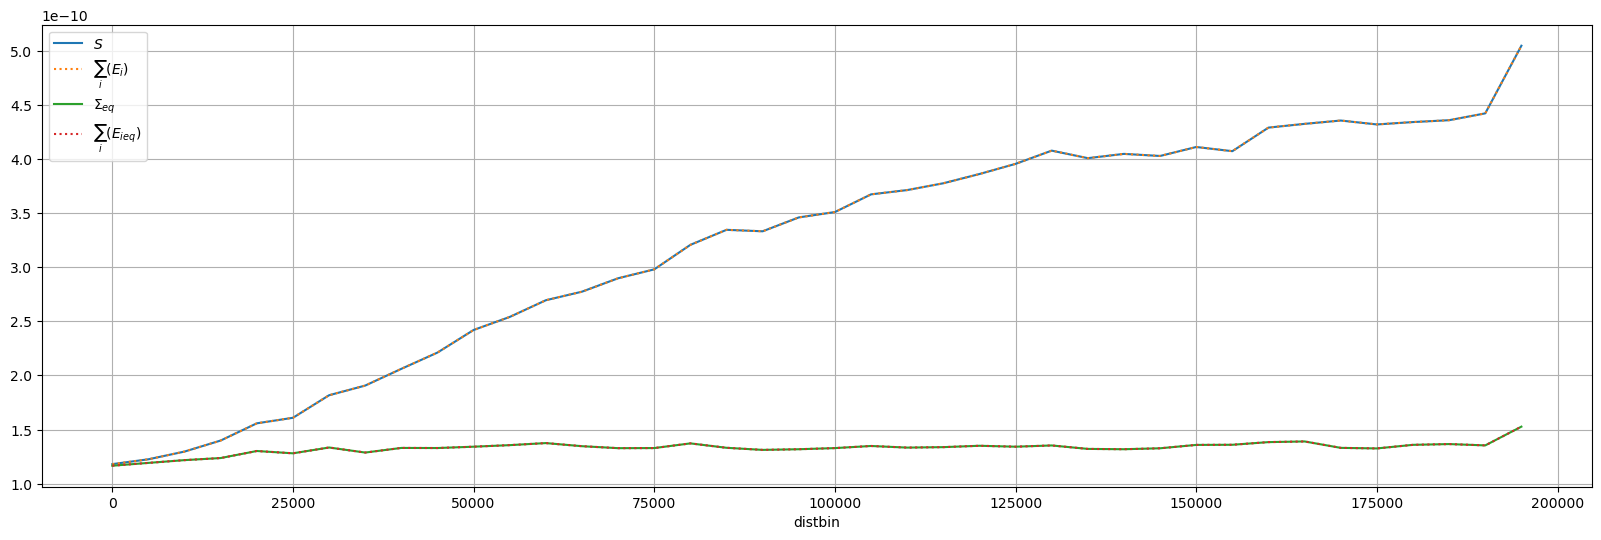

In [45]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))

df2.groupby("distbin")['s'].mean().plot(label=r'$S$', ax=ax)
(df.groupby("distbin")['sume'].mean()).plot(label=r'$\sum_i(E_i)$', ax=ax, ls=':')

df2.groupby("distbin")['sd'].mean().plot(label=r'$\Sigma_{eq}$', ax=ax)
(df.groupby("distbin")['sumed'].mean()).plot(label=r'$\sum_i(E_{ieq})$', ax=ax, ls=':')
ax.grid()
ax.legend()

## Check $B_{i} + E_{i} = A_{i}$


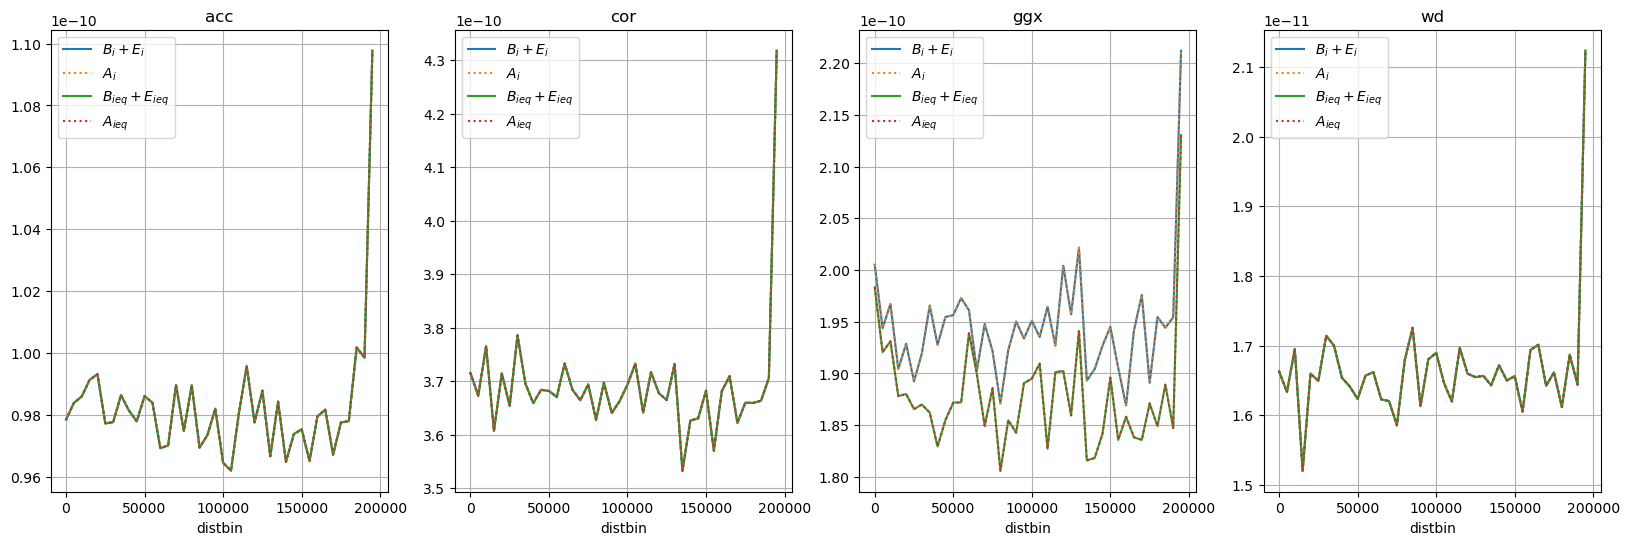

In [46]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    (df.groupby("distbin")['b_'+v].mean()+df.groupby("distbin")[v+'s'].mean()).plot(label=r'$B_i + E_i$', ax=ax)
    (df2.groupby("distbin")[v].mean()).plot(label=r'$A_i$', ax=ax, ls=':')
    
    (df.groupby("distbin")['bd_'+vd].mean()+df.groupby("distbin")[vd+'sd'].mean()).plot(label=r'$B_{ieq} + E_{ieq}$', ax=ax)
    (df2.groupby("distbin")[vd].mean()).plot(label=r'$A_{ieq}$', ax=ax, ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

# Contributions $X_{ij} = -2\langle a_i a_j \rangle$ en fonction de $X_{ijeq} = -2\langle a_i a_j \rangle$

- Pour l'équilibre sans erreur de colocalisation:
  $X_{ijeq} = -2\langle b_i b_j \rangle$ ne dépend pas de dl
  
- Pour l'équilibre avec erreur de colocalisation:
    - pour $i,j\neq 3$ :
      $$X_{ij} = X_{ijeq} = -2\langle b_i b_j \rangle$$
    - pour $i=3$, $j\neq 3$, par exemple j=1:
      $$X_{31} = -2\langle a'_3 a_1 \rangle = -2\langle a'_3-a_3+a_3 a_1 \rangle = -2\langle d_a a_1 \rangle + X_{31eq}$$
- On remarque que $\sum X_{ij} = \sum_i B_i$

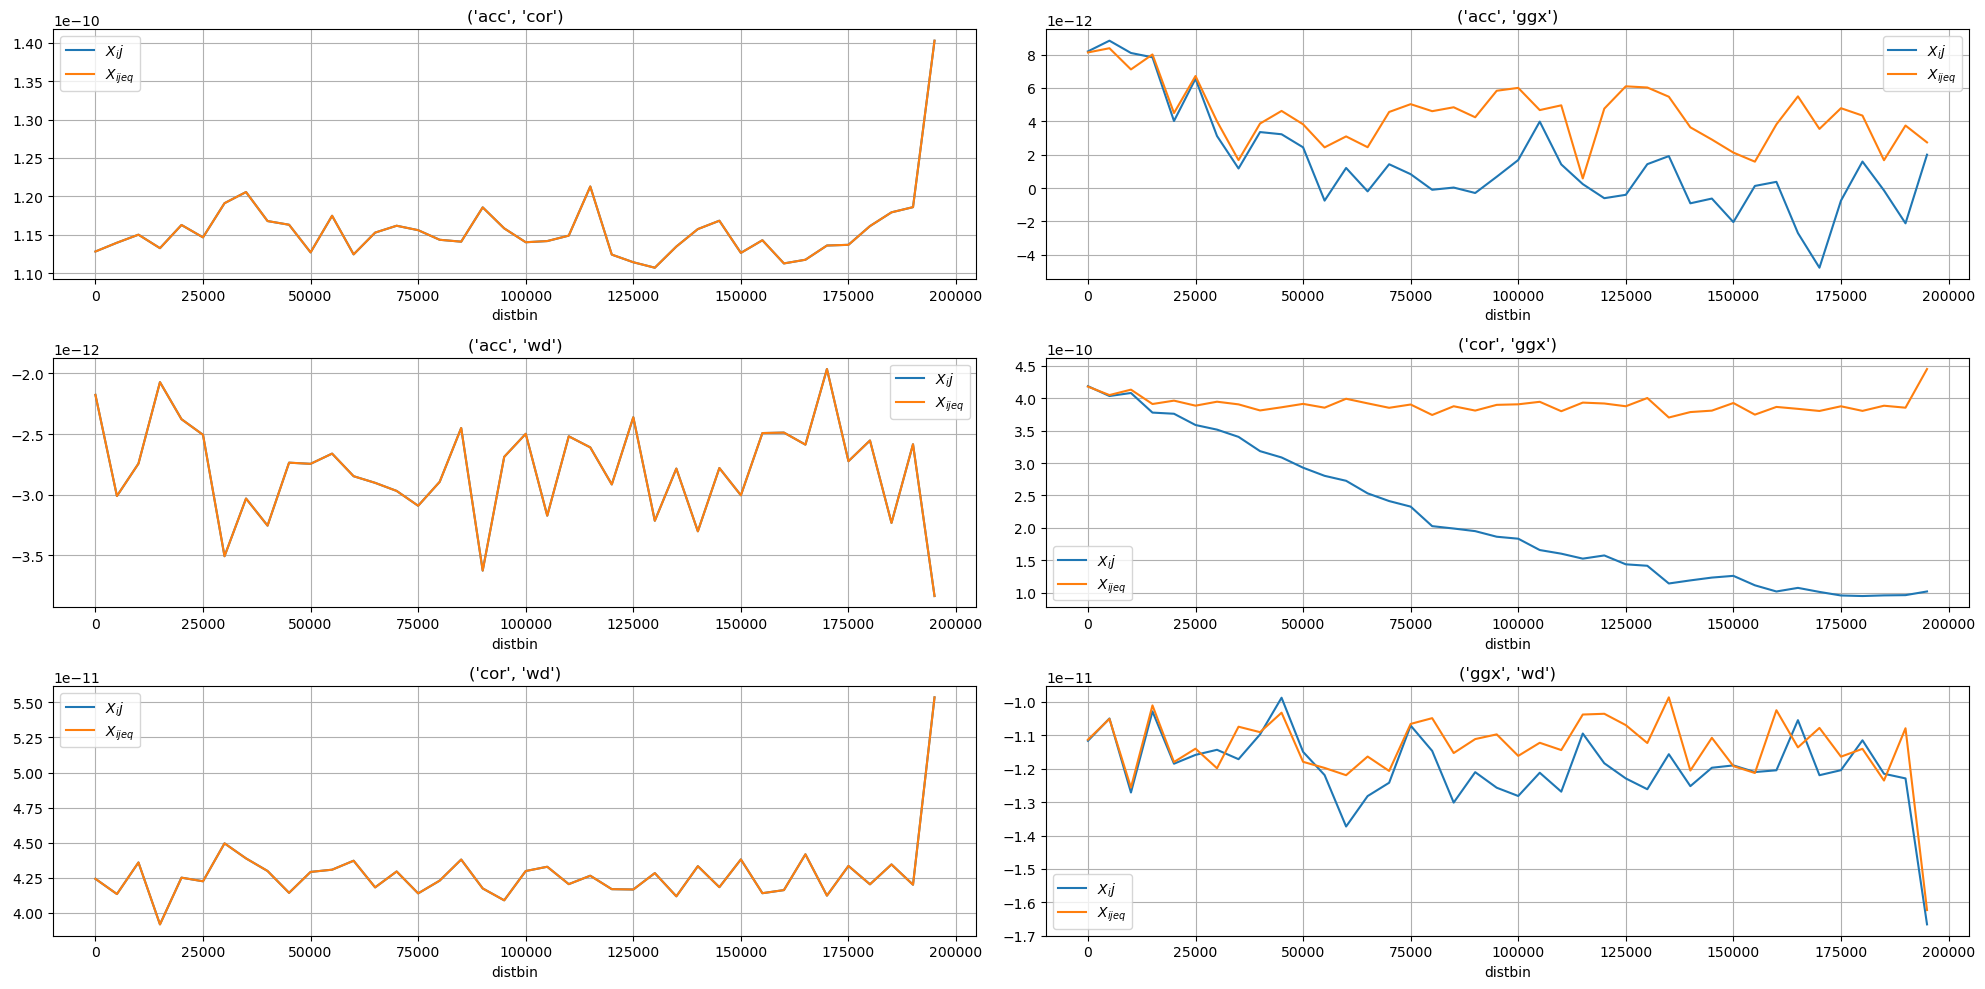

In [54]:
fig, axs = plt.subplots(3, 2,figsize=(20,10))
axs = axs.flatten()
for i in range(len(comb)):
    ax = axs[i]
    c, cd = comb[i], combd[i]
    (-2 * df.groupby("distbin")[f'{c[0]}_{c[1]}'].mean()).plot(label=r'$X_ij$', ax=ax)
    (-2*df.groupby("distbin")[f'{cd[0]}_{cd[1]}'].mean()).plot(label=r'$X_{ijeq}$', ax=ax)
    ax.grid()
    ax.set_title(c)
    ax.legend()
fig.tight_layout()

## A propos de $\Sigma$
$$\Sigma = \sum_i A_i = \sum_i B_i +\sum_i E_i $$ 
$\Sigma$ n'est pas impacté par l'erreur de colocalisation, et on a : $$\Sigma - \Sigma_{eq} = A'_3-A_3$$

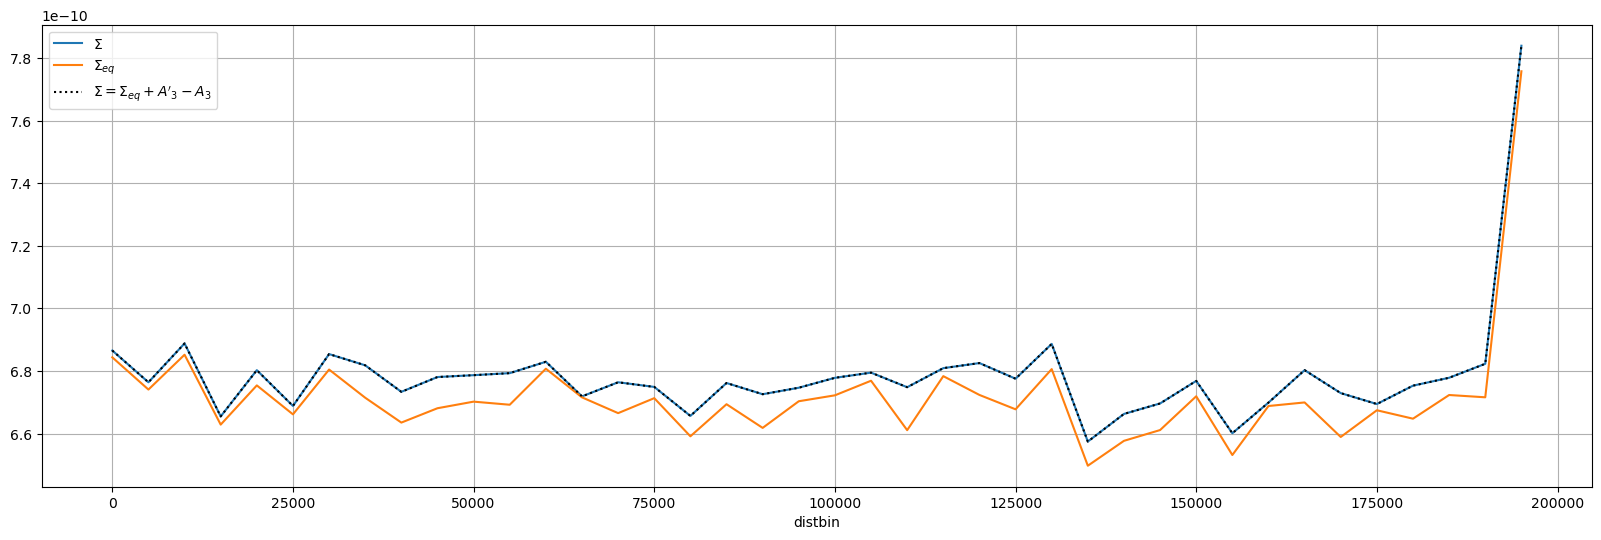

In [48]:
df2['sig'] = df2[[v for v in var]].sum(axis=1)
df2['sigd'] = df2[[v for v in vard]].sum(axis=1)
fig, ax= plt.subplots(1, 1,figsize=(20,6))
df2.groupby("distbin")['sig'].mean().plot(label=r'$\Sigma$', ax=ax)
df2.groupby("distbin")['sigd'].mean().plot(label=r'$\Sigma_{eq}$', ax=ax)
(df2.groupby("distbin")['sigd'].mean() + df2.groupby("distbin")['ggx'].mean() - df2.groupby("distbin")['ggxd'].mean()).plot(label=r"$\Sigma = \Sigma_{eq} + A'_3-A_3$", ax=ax, ls=':', c='k')
ax.grid()
ax.legend()

In [49]:
df['sumb'] = df[['b_'+v for v in var]].sum(axis=1)
df['sumbd'] = df[['bd_'+v for v in vard]].sum(axis=1)
df['sume'] = df[[v+'s' for v in var]].sum(axis=1)
df['sumed'] = df[[v+'sd' for v in vard]].sum(axis=1)

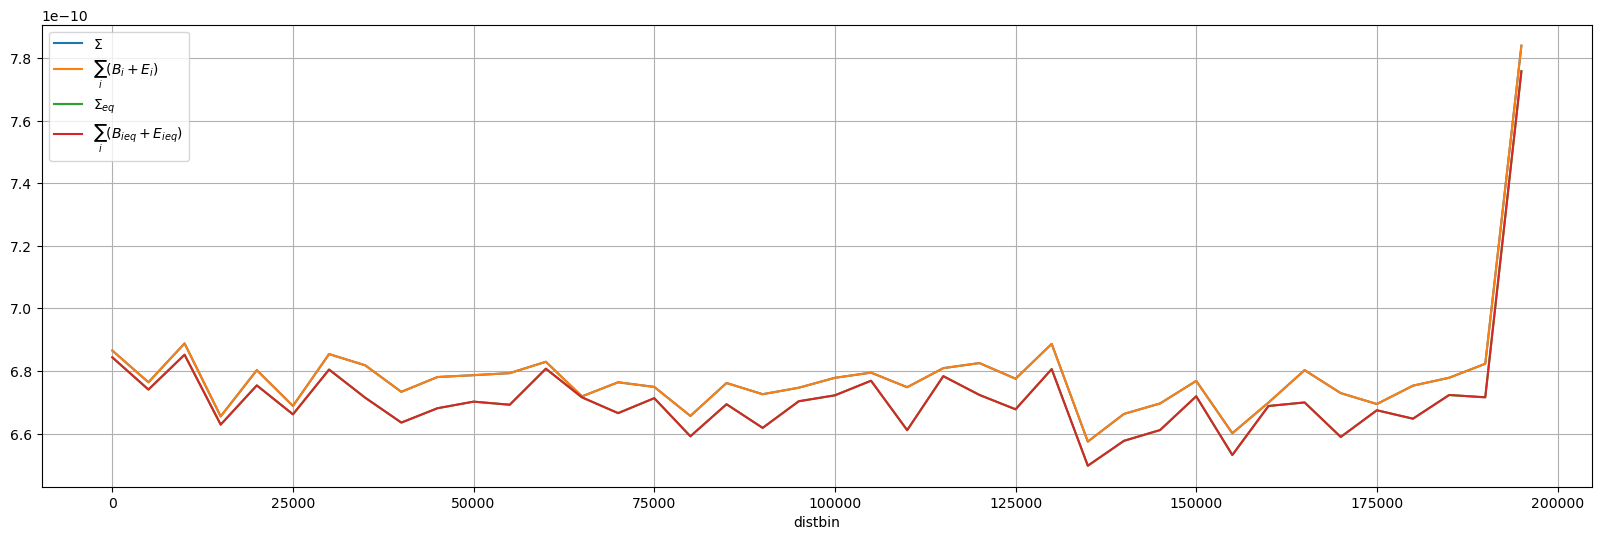

In [50]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))

df2.groupby("distbin")['sig'].mean().plot(label=r'$\Sigma$', ax=ax)
(df.groupby("distbin")['sumb'].mean() + df.groupby("distbin")['sume'].mean()).plot(label=r'$\sum_i(B_i+E_i)$', ax=ax)

df2.groupby("distbin")['sigd'].mean().plot(label=r'$\Sigma_{eq}$', ax=ax)
(df.groupby("distbin")['sumbd'].mean() + df.groupby("distbin")['sumed'].mean()).plot(label=r'$\sum_i(B_{ieq}+E_{ieq})$', ax=ax)
ax.grid()
ax.legend()

# Différence A_3/A'_3 ??
A priori, ne devait pas avoir de grosse différences, ni de tendance, mais sur tout les DL on a globalement A'_3 < A_3, mais pourquoi ???

<Axes: >

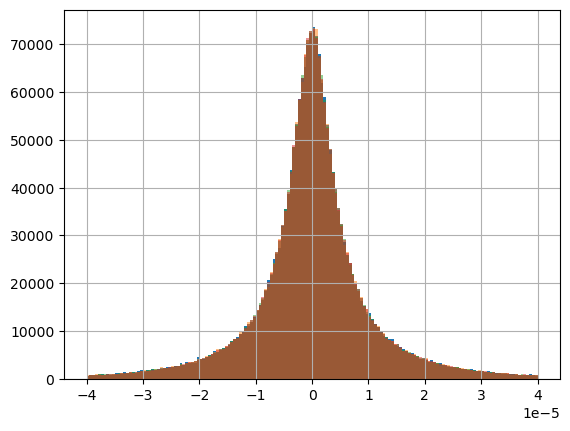

In [51]:
df_.ggx.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True)
df_.ggxd.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha = 0.5)
df.ggx.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha=0.5)
df.ggxd.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha = 0.5)

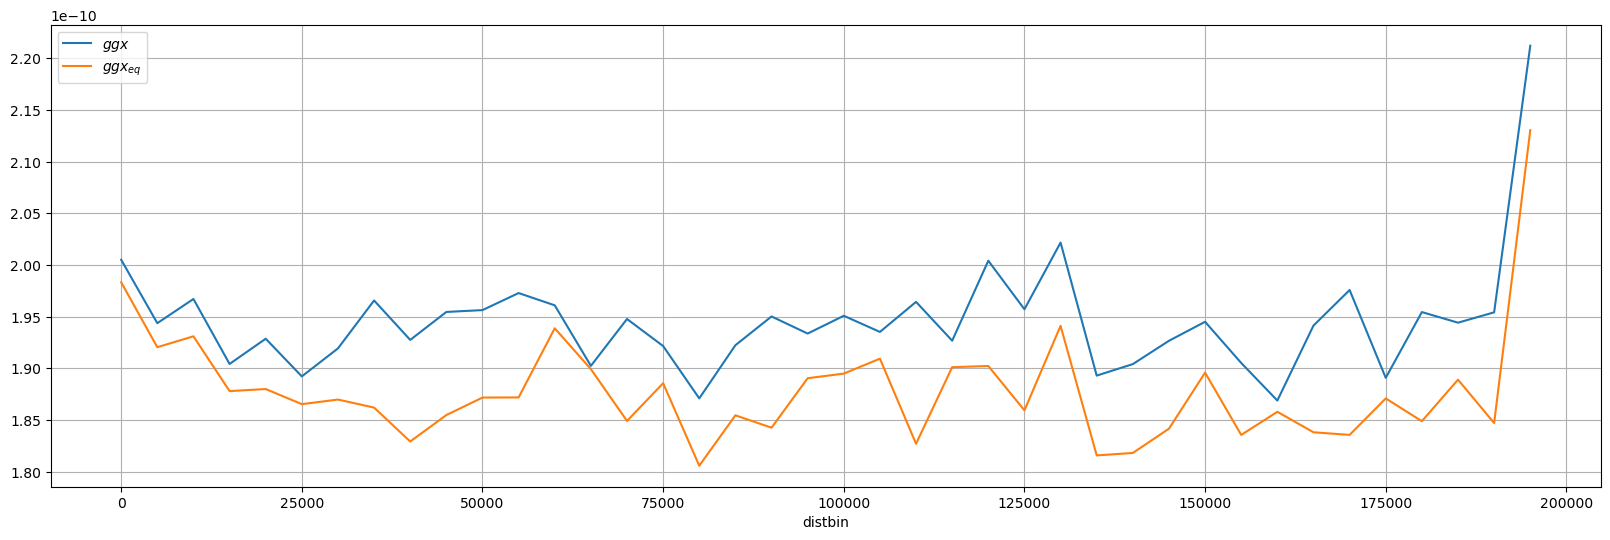

In [52]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))
df2.groupby("distbin")['ggx'].mean().plot(label=r'$ggx$', ax=ax)
df2.groupby("distbin")['ggxd'].mean().plot(label=r'$ggx_{eq}$', ax=ax)
ax.grid()
ax.legend()

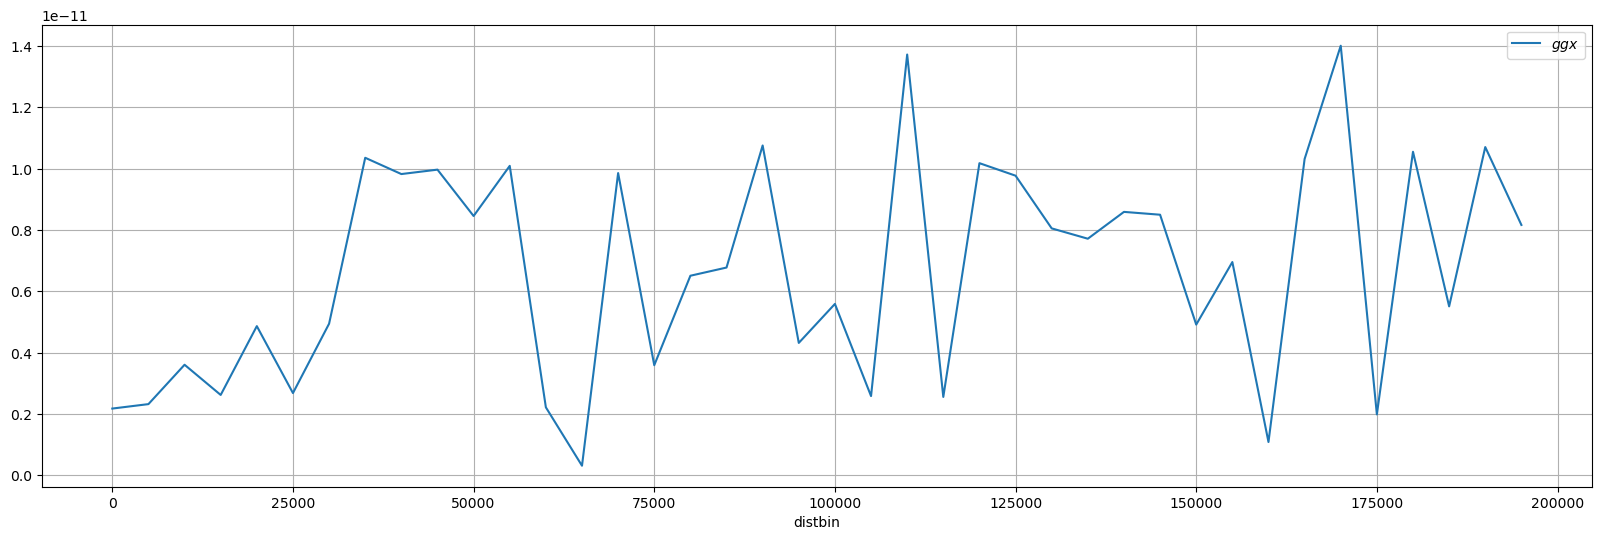

In [53]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))
(df2.groupby("distbin")['ggx'].mean()-df2.groupby("distbin")['ggxd'].mean()).plot(label=r'$ggx$', ax=ax)
ax.grid()
ax.legend()

_________________________
_________________________
# Comment prendre en compte correctement l'erreur de colocalisation ??

On a montré ci-dessus que :
- Pour le résidu :
$$ S - S_{eq} = D_a + 2\langle d_a o_{eq} \rangle $$
avec $\langle d_a o_{eq} \rangle$ petit devant $D_a$ et $O_eq$ : 
$\langle d_a o_{eq} \rangle/D_a = -16.1\%$ pour DL<25km 
$\langle d_a o_{eq} \rangle/S_{eq} = -2\%$ pour DL<25km 

- Pour $i\neq3$, par exemple i=1:
$$ B_{1eq} = B_1+\langle a_1 d_a \rangle $$
$$ E_{1eq} = E_1-\langle a_1 d_a \rangle $$

- Pour $i=3$:
$$ E_{3eq} = E_3 - \langle d_a\sum_{j\neq3} a_j\rangle + A_3 - A'_3$$
$$ B_{3eq} = B_3 +\sum_{j\neq 3}\langle a_j d_a \rangle $$

- pas facile (impossible ?) d'estimer le $\langle a_i d_a \rangle$
- Pour le along-track, je peux connaître un $\langle d_a \rangle$ et un $D_a$ et $A_3 - A'_3$ en fonction de DL mais seulement sur la direction de la trace ... un $\langle a'_3 d_a \rangle$ aussi ?
- L'origine sur les courbes sans DL donne une idée

In [1]:
cluster.close()

NameError: name 'cluster' is not defined